In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [5]:
from torchvision import datasets, transforms
data_path = '../chap7/data'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [6]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [7]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]


In [8]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

In [9]:
numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [10]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

In [11]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [12]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

# 8.1
# 8.2

In [13]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [14]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [15]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

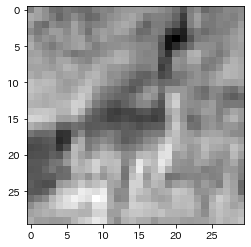

In [16]:
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

## 8.2.1

In [17]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1) # パディングあり
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

## 8.2.2

In [18]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

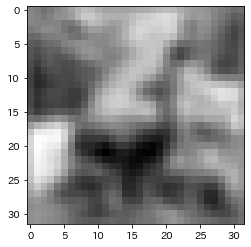

In [19]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

In [20]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                    [-1.0, 0.0, 1.0],
                                    [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

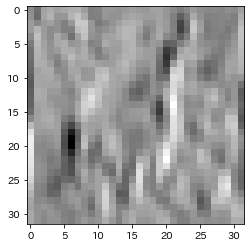

In [21]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0, 0].detach(), cmap="gray")
plt.show()

## 8.2.3

In [22]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

## 8.2.4

In [23]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ...
)

In [24]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ... 重要な部分が抜けている
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2)
)

In [25]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [26]:
model(img.unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)